In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from datasets import load_from_disk
from transformers import AutoTokenizer

import os
import itertools
import json
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/pbs.3067811.pbsha.ib.sockeye/matplotlib-5shwz1vk because the default path (/home/gregdeon/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# work around crazy huggingface requirements
from datasets.utils.logging import set_verbosity_error
set_verbosity_error()

In [4]:
# from spotlight.datasets import *
from torch_spotlight.utils import *
from torch_spotlight.plot_utils import *

setupPlots()

In [5]:
# on our cluster, use tmpdir for data and models
os.environ['DATA_DIR'] = os.environ['TMPDIR']
os.environ['MODEL_DIR'] = os.environ['TMPDIR']

In [6]:
data_dir = os.environ['DATA_DIR'] 
model_dir = os.environ['MODEL_DIR'] 
amazon_dir = os.path.join(data_dir, 'amazon')
amazon_model_path = os.path.join(model_dir, 'amazon')
squad_dir = os.path.join(data_dir, 'squad')
squad_model_path = os.path.join(model_dir, 'squad')

# Amazon reviews

## Dataset + tokenizer

In [7]:
dataset = load_from_disk(amazon_dir)['test']

In [8]:
num_examples = 20000
amazon_labels = [dataset[i]['label'] for i in range(num_examples)]

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english", 
    cache_dir=amazon_model_path, 
    do_lower_case=True, 
    do_basic_tokenize=True,
    local_files_only=True
)

In [10]:
tokens = []
unique_tokens = []
for i in tqdm(range(num_examples)):
    tokenized = tokenizer(dataset[i]['content'], padding=True, return_tensors='pt')
    tokens.append(tokenized['input_ids'].flatten())
    unique_tokens.append(torch.unique(tokenized['input_ids']))

100%|██████████| 20000/20000 [00:13<00:00, 1518.79it/s]


In [16]:
review_lengths = []
for i in tqdm(range(num_examples)):
    review_lengths.append(len(dataset[i]['content'].split()))
review_lengths = np.array(review_lengths)

100%|██████████| 20000/20000 [00:01<00:00, 17057.46it/s]


(array([2509., 3849., 3416., 2773., 2325., 1927., 1384., 1150.,  568.,
          99.]),
 array([  8. ,  27.4,  46.8,  66.2,  85.6, 105. , 124.4, 143.8, 163.2,
        182.6, 202. ]),
 <BarContainer object of 10 artists>)

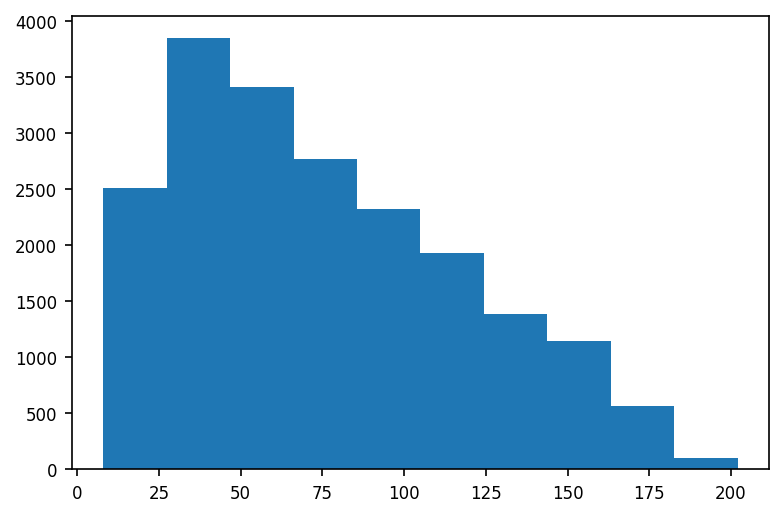

In [17]:
plt.hist(review_lengths)

In [23]:
def getAverageReviewLength(weights):
    return weights @ review_lengths / (weights.sum()) 

## Model outputs

In [18]:
inference = loadResults('inference_results/amazon_test_sst.pkl')
embeddings = inference.embeddings
outputs = inference.outputs 
losses = inference.losses

In [25]:
def displayReviews(idx_list):
    for idx in idx_list:
        example = dataset[idx]
        display(example['content'])
        display(example['label'])
        display(losses[idx])
        print()
        
def getCommonTokens(weights, smoothing=0.01, print_first=50):
    token_frequencies = defaultdict(float)
    token_frequencies_spotlight = defaultdict(float)

    weights_uniform = np.full_like(weights, 1 / len(weights))

    num_examples = len(weights)
    for i in tqdm(range(num_examples)):
        for token in unique_tokens[i]:
            token_frequencies[token.item()] += weights_uniform[i]
            token_frequencies_spotlight[token.item()] += weights[i]
            
    token_lrs = {k: (smoothing+token_frequencies_spotlight[k]) / (smoothing+token_frequencies[k]) for k in token_frequencies}
    tokens_sorted = list(map(lambda x: x[0], sorted(token_lrs.items(), key=lambda x: x[1])[::-1]))
    for i, (token) in enumerate(tokens_sorted[:print_first]):
        print('%15s %.4f %.4f %4.2f' % (tokenizer.decode(token), token_frequencies[token], token_frequencies_spotlight[token], token_lrs[token]))

In [20]:
displayReviews(losses.argsort().tolist()[::-1][:10])

"This production is so awesome we can't stop watching it over and over. It is one of the finest vocal performances I have ever seen."

0

tensor(9.0710)

'Very nice peridot necklace. I bought the 3-piece set for a birthday gift, and I was proud to give it as a gift.'

0

tensor(8.9754)

'love the movie. made me cry. I was expecting the original movie but it still is a wonderful story to watch'

0

tensor(8.9253)

'This was my first encounter with the magical realism style and I love it! The Buendia family is quite possibly the most intriguing I have encountered in any book. A must read.'

0

tensor(8.9095)

'This one gift I could give my grown daughter. I read this book over and over to her as a child. It was in wonderful condition!'

0

tensor(8.8914)

"I watched the movie on Cartoon Network about two years ago. It's an excellent movie, I tell you. It's facinating!!! ^_^I loved the characters and their personalities. I seriously loved the art designs animation. It brings out the true life of the movie. In my opinion, this DVD is great! You should get this DVD and soon. It ROCKS! ^_^!"

0

tensor(8.8772)

'Like it. Love it. Live in Paris will always be in my top 5. She is a star with this incredible band. Some of her originals are too melancholy for me, but she is truly unique in her talents. Who else can compose, sing and play jazz piano like that? Who was the girl?'

0

tensor(8.7896)

'This is Hawaiian music done very well. Darnall is a master arranger and player of string instruments. Most songs could be background music. However! Over the Rainbow is pure genius. Unforgettable. I would use the word, haunting. I think Judy Garland would approve.'

0

tensor(8.7384)

'Jerry Garcia was a stone cold genius. The Grateful Dead was his backup band. Bob Weir\'s solo work is easily as good as the solo work of Bill Wyman, Keith Moon, Dave Davies, and Clarence Clemmons. From a 40 year career this is the "best" they could come up with?'

0

tensor(8.7288)

'The background music is not clear and the CD was a waste of money. One star is too high.'

1

tensor(8.6523)

In [24]:
getAverageReviewLength(np.ones(len(review_lengths)) / len(review_lengths))

75.74699999999997

In [26]:
(losses > 4.5).float().mean()

tensor(0.0495)

In [27]:
high_loss_idx = (losses > 4.5)
high_loss_weights = high_loss_idx / high_loss_idx.sum()
getAverageReviewLength(high_loss_weights)

tensor(68.7889, dtype=torch.float64)

In [33]:
loss_weights = (losses > 4.5)
loss_weights = loss_weights / loss_weights.sum()
getCommonTokens(loss_weights, 0.005, 20)

100%|██████████| 20000/20000 [00:10<00:00, 1838.91it/s]


            ##4 0.0044 0.0141 2.03
         potter 0.0022 0.0091 1.94
          ##ven 0.0025 0.0091 1.88
            gas 0.0025 0.0091 1.87
           cold 0.0064 0.0162 1.86
         access 0.0026 0.0091 1.85
          ##hen 0.0022 0.0081 1.80
           ##ia 0.0068 0.0162 1.79
          adapt 0.0058 0.0141 1.77
       electric 0.0024 0.0081 1.77
        problem 0.0279 0.0525 1.75
             bu 0.0031 0.0091 1.73
            rom 0.0014 0.0061 1.73
        teacher 0.0044 0.0111 1.71
         rating 0.0086 0.0182 1.70
            ##8 0.0027 0.0081 1.70
          harry 0.0033 0.0091 1.70
      otherwise 0.0104 0.0212 1.70
             64 0.0009 0.0051 1.69
           wars 0.0021 0.0071 1.69


## Spotlights

In [21]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadResults(f'spotlight_results/amazon_test_sst_0.05_spherical_{count}.pkl')

In [22]:
displayReviews(spotlights[1].weights.argsort().tolist()[::-1][:20])

'The holiday music is very enjoyable but I purchased this CD to download to my IPOD and it will not download to iTunes and you cannot burn a CD from it.'

0

tensor(0.0493)

"I'm sure this is a great product, but my speakers are 9 foot away, and i massively can't be bothered to go and move them. I left the cable on the kitchen table.Also, the packaging has some very racial things stated in it."

0

tensor(0.0518)

"Jake Grafton has to teach marines what it's like to be on an aircraft carrier. Landing and taking off on a slipery deck, learning all the parts to a carrier and how to put up with Flap LeBeau. This book you can't put down, I couldn't."

1

tensor(3.3566)

"I'm using this on a Win98SE PC to connect to an Apple AirPort Base Station. It sees the base station fine, but when the Belkin is touching the base station it transmits at 70% signal strength. My PowerBook can see the base station at 100% one floor up, 80% on the second floor up.Belkin software was easy to use and configure. Maybe my HP Pavilion causes a lot of RF interference? Unknown, but I'd try a Linksys or Hawking over the Blekin. Don't be swayed by the price."

0

tensor(0.0434)

'these head phones are great for truck drivers, the battery life is on ly about 8 hours other than that there perfect'

1

tensor(3.0363)

'So I ordered this with tahitian cardio, which is AMAZING. So after doing that and the tahitian hip hop (they come together) I decided to try the Cardio Hula. When i took it out of its schrink wrapped case, it definately did look a little funny. I put it in my Boyfriends XBOX 360 and it didnt recognize it as a disk. I tried it in our dvd player, and it still didnt recognise it as a dvd. I looked at the surface, to see if there was any scratches, and to my confusion it was blue, like a DVD-R. I flipped it over and looked more closely at the top and noticed that whoever printed the label needed their printer heads cleaned. I ordered if FROM amazon, I even got the supersaver shipping, which brought my bootleg DVD in record time. I only can play it on my laptop which has a TINY screen.Thanks Amazon, thanks'

0

tensor(0.0346)

'I paid less and got the exact same Tivo wireless adapter as sold by Tivo. I have had no problems and now I get updates and download shows to my computer without any cables..'

1

tensor(3.5884)

"Great Backpack! Love the color! The only thing, is that it gets dirty easily. I got a pen mark on the pocket, and I'm not sure how to remove it :("

1

tensor(2.8205)

'The new ipods do not charge with the pioneer cable, and this was the solution to the problem. Now my 4th gen nano charges no problem!'

1

tensor(3.1895)

'I BOUGHT THIS PRODUCT FOR MY DDP KIT AND I HAVE A WATER PURIFIER SO I CAN DROP A TAB IN MY WATER AND DRINK IT WITH NO WORRIES'

1

tensor(3.3242)

"This product is good for UK only. To play in USA you need to find a DVD player which has capability for changing Region Code to UK and that you may be able to do it on computer but not on DVD player in USA. I order it in USA, prodact came from Uk and I couldn't play it on my most advanced DVD player."

0

tensor(0.0384)

'The first time I put this CD into the Discman, I was feelin it. The album was pretty hot. Than I heard it again. The beats are tight, but Bone sounds like Popeye. They gotta slow down the flow.'

0

tensor(0.0475)

'Les recomiendo que siempre tengan 2 baterías, la original con la que viene la cámara, en mi caso la Panasonic Lumix DMC-TZ5K, y otra de reemplazo para que nunca se pierdan ningún momento por tener la batería descargada. Carga perfectamente en el cargador original de la cámara y su precio es muy muy bajo... comparen y verán.'

1

tensor(3.0603)

'muy buen producto. rapido facil y a tiempo la entrega. sin contratiempos en todo el proceso. lo recomiendo a a'

1

tensor(3.1159)

'I was very excited to get this movie on dvd which did arrive very promptly. Unfortunately, this disk from Movie Mars will not play on my dvd player. When I press play, the message CANNOT PLAY is displayed. I have ordered many dvds from Amazon and have never had this problem.'

0

tensor(0.0251)

"Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries."

1

tensor(3.9011)

'Me recordó aquellos libros de la Generación Kronen: un libro muy pop donde ha calado el lenguaje cinematográfico para presentar la trama. Personajes bien definidos. Un libro entre Yorkshire y la nostalgia del Levante español. Sorprendente y entretenido.'

1

tensor(3.0348)

'Great workout earphones, stays put and withstands all the sweating I do! Only wish the cord was so squirmy.'

1

tensor(2.5699)

'These are a great way to keep your multiple remotes organized and your tabletop clutter free. I bought 2 of the black.'

1

tensor(3.4635)

"The shoe seemed nice. I purchased the 2E version since I read in another review that they can be tight. Unfortunately, the top of the tongue bit into my ankle when I tied the shoe. Didn't matter which sock I wore. I had to return."

0

tensor(0.0433)

In [93]:
getAverageReviewLength(spotlights[1].weights)

79.0616454849033

In [28]:
getCommonTokens(spotlights[1].weights, 0.005, 20)

100%|██████████| 20000/20000 [00:04<00:00, 4329.97it/s]


            que 0.0028 0.0153 2.60
            est 0.0023 0.0112 2.22
           como 0.0011 0.0077 2.08
              y 0.0071 0.0200 2.07
            las 0.0016 0.0087 2.05
            tod 0.0011 0.0073 2.00
             es 0.0060 0.0166 1.96
             la 0.0080 0.0198 1.90
             si 0.0045 0.0129 1.87
            por 0.0017 0.0076 1.86
           ##as 0.0057 0.0149 1.85
           para 0.0029 0.0094 1.83
             ot 0.0015 0.0069 1.82
           este 0.0014 0.0063 1.75
            los 0.0022 0.0073 1.71
             el 0.0060 0.0136 1.69
          ##ros 0.0015 0.0058 1.66
          ##bro 0.0015 0.0057 1.64
         ##cion 0.0012 0.0051 1.64
             mu 0.0083 0.0168 1.63


In [30]:
getAverageReviewLength(spotlights[2].weights)

88.72059491905526

In [29]:
getCommonTokens(spotlights[2].weights, 0.005, 20)

100%|██████████| 20000/20000 [00:04<00:00, 4161.77it/s]

          super 0.0104 0.0210 1.69
        wearing 0.0035 0.0093 1.68
            job 0.0239 0.0435 1.68
         prefer 0.0057 0.0130 1.67
         bigger 0.0035 0.0092 1.67
            rev 0.0039 0.0098 1.67
           hang 0.0028 0.0080 1.65
       discover 0.0029 0.0080 1.64
        killing 0.0028 0.0078 1.63
         ##ling 0.0059 0.0128 1.63
           slip 0.0026 0.0075 1.63
         source 0.0043 0.0101 1.63
       compared 0.0086 0.0171 1.62
            ##x 0.0118 0.0222 1.61
         pushed 0.0013 0.0052 1.61
           thus 0.0037 0.0090 1.61
             aw 0.0023 0.0067 1.59
         harder 0.0015 0.0054 1.59
             bt 0.0013 0.0051 1.59
        intense 0.0023 0.0067 1.59


In [31]:
getAverageReviewLength(spotlights[3].weights)

80.69196854125622

In [32]:
getCommonTokens(spotlights[3].weights, 0.005, 20)

100%|██████████| 20000/20000 [00:04<00:00, 4056.87it/s]

        problem 0.0279 0.0476 1.60
       returned 0.0091 0.0173 1.58
            que 0.0028 0.0070 1.54
         hoping 0.0092 0.0169 1.54
             ok 0.0174 0.0294 1.53
  unfortunately 0.0158 0.0269 1.53
        ##point 0.0113 0.0199 1.53
          ##ssa 0.0082 0.0150 1.51
      returning 0.0048 0.0096 1.49
        however 0.0503 0.0772 1.49
            las 0.0016 0.0049 1.48
              $ 0.0234 0.0370 1.48
          maybe 0.0297 0.0461 1.47
          ##und 0.0071 0.0128 1.46
            est 0.0023 0.0056 1.45
           okay 0.0088 0.0150 1.44
         unless 0.0141 0.0225 1.44
         wouldn 0.0182 0.0284 1.44
           ##as 0.0057 0.0105 1.44
            dry 0.0088 0.0147 1.43


# SQuAD

## Dataset + tokenizer

In [36]:
dataset = load_from_disk(squad_dir)['validation']

In [37]:
categories = list(set(dataset['title']))

In [38]:
def filter_short_examples(example):
    example_length = len(tokenizer(
        example["question"],
        example["context"],
    )['input_ids'])
    return example_length < 384
short_dataset = dataset.filter(filter_short_examples)

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors


In [39]:
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased-distilled-squad", 
    cache_dir=squad_model_path, 
    local_files_only=True
)

In [40]:
unique_tokens = []
for i in tqdm(range(len(short_dataset))):
    example = short_dataset[i]
    tokenized = tokenizer(example["question"], example["context"], return_tensors='pt')
    unique_tokens.append(torch.unique(tokenized['input_ids']))

100%|██████████| 10386/10386 [00:10<00:00, 971.55it/s]


## Model outputs

In [41]:
inf_results = loadResults('inference_results/squad_val_bert_cls.pkl')
embeddings = inf_results.embeddings
outputs = inf_results.outputs
losses = inf_results.losses

In [50]:
def displayReviews(idx_list):
    for idx in idx_list:
        example = short_dataset[idx]
        display(example['question'])
        display(example['answers']['text'])
        display(losses[idx])
        print()
        
def getCommonTokens(weights, smoothing=0.01, print_first=50):
    token_frequencies = defaultdict(float)
    token_frequencies_spotlight = defaultdict(float)

    weights_uniform = np.full_like(weights, 1 / len(weights))

    num_examples = len(weights)
    for i in tqdm(range(num_examples)):
        for token in unique_tokens[i]:
            token_frequencies[token.item()] += weights_uniform[i]
            token_frequencies_spotlight[token.item()] += weights[i]
            
    token_lrs = {k: (smoothing+token_frequencies_spotlight[k]) / (smoothing+token_frequencies[k]) for k in token_frequencies}
    tokens_sorted = list(map(lambda x: x[0], sorted(token_lrs.items(), key=lambda x: x[1])[::-1]))
    for i, (token) in enumerate(tokens_sorted[:print_first]):
        print('%15s %.4f %.4f %4.2f' % (tokenizer.decode(token), token_frequencies[token], token_frequencies_spotlight[token], token_lrs[token]))
        
def getTopicDistribution(weights, smoothing=0.01):
    topic_frequencies = defaultdict(float)
    topic_frequencies_spotlight = defaultdict(float)

    weights_uniform = np.full_like(weights, 1 / len(weights))

    num_examples = len(weights)
    for i in range(num_examples):
        example = short_dataset[i]
        category = example['title']
        topic_frequencies[category] += weights_uniform[i]
        topic_frequencies_spotlight[category] += weights[i]
        
    topic_ratios = {c: (smoothing + topic_frequencies_spotlight[c]) / (smoothing + topic_frequencies[c]) for c in topic_frequencies}

    categories_sorted = map(lambda x: x[0], sorted(topic_ratios.items(), key=lambda x: x[1], reverse=True))
    for category in categories_sorted:
        print('%.3f %.3f %.2f %s' % (topic_frequencies[category], topic_frequencies_spotlight[category], topic_ratios[category], category))

In [51]:
displayReviews(losses.argsort().tolist()[::-1][:10])

'Who disliked the affiliate program?'

['passed',
 'Several University of Chicago professors',
 'Several University of Chicago professors']

tensor(15.3882)

'In which year were the North and South Courts opened?'

['Secretariat Wing', 'June 1862', 'June 1862']

tensor(14.6645)

"Dutch architect Janjaap Ruijssenaars's performative architecture 3D-printed building is scheduled to be built when?"

['Working versions of 3D-printing building technology are already printing',
 '2014',
 '2014']

tensor(14.0288)

'Did Tesla graduate from the university?'

['no', 'not', 'He never graduated']

tensor(13.2189)

'What position does Jerricho Cotchery play?'

['receivers', 'receivers', 'receivers']

tensor(12.9204)

'What is attributed to the income inequality in the United States?'

['less willing to travel or relocate',
 'women not taking jobs due to marriage or pregnancy',
 'not taking jobs due to marriage or pregnancy']

tensor(12.9135)

'Who organized the Britain Can Make It exhibition?'

['Festival of Britain (1951)',
 'Council of Industrial Design',
 'the Council of Industrial Design']

tensor(12.8970)

'If polynomial time can be utilized within an NP-complete problem, what does the imply P is equal to?'

['NP', 'NP', 'NP']

tensor(12.8866)

'What is one way of digital civil disobedience that can have far reaching consequences?'

['sending an email', 'email', 'Supreme Court case', 'broadcasting']

tensor(12.7510)

'How has civil disobedience evolved in current times?'

['code-word describing the activities of muggers, arsonists, draft evaders',
 'utterly debased',
 'become utterly debased',
 'become utterly debased',
 'become utterly debased']

tensor(12.4873)

In [52]:
# Get top 2% losses
np.quantile(losses, 0.98)

7.583634710311875

In [49]:
loss_weights = (losses > 7.58)
loss_weights = loss_weights / loss_weights.sum()
getCommonTokens(loss_weights, 0.005, 20)

100%|██████████| 10386/10386 [00:08<00:00, 1288.97it/s]


          sacks 0.0079 0.0529 4.49
            ##½ 0.0065 0.0433 4.18
        tackles 0.0065 0.0433 4.18
       confused 0.0020 0.0240 4.14
          ##bed 0.0181 0.0865 3.96
        ##ience 0.0184 0.0865 3.91
          yards 0.0161 0.0769 3.89
       behavior 0.0052 0.0337 3.79
     touchdowns 0.0065 0.0385 3.76
     defendants 0.0014 0.0192 3.76
     protesters 0.0015 0.0192 3.70
     cornerback 0.0041 0.0288 3.70
  interceptions 0.0081 0.0433 3.69
         fumble 0.0094 0.0481 3.68
         ##ling 0.0057 0.0337 3.62
         ##ient 0.0086 0.0433 3.56
      touchdown 0.0078 0.0385 3.40
          judge 0.0050 0.0288 3.38
         dallas 0.0037 0.0240 3.35
      defensive 0.0065 0.0337 3.35


## Spotlights

In [47]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadResults(f'spotlight_results/squad_val_bert_cls_0.05_spherical_{count}.pkl')

### Common tokens

In [53]:
getCommonTokens(spotlights[1].weights, 0.005, 20)

100%|██████████| 10386/10386 [00:03<00:00, 2862.73it/s]

         packet 0.0048 0.0236 2.91
          ##bed 0.0181 0.0578 2.72
        ##ience 0.0184 0.0556 2.59
        packets 0.0032 0.0160 2.57
      switching 0.0047 0.0191 2.48
        circuit 0.0039 0.0166 2.41
             np 0.0058 0.0209 2.40
            pad 0.0041 0.0168 2.38
         ##ient 0.0086 0.0268 2.34
           ##so 0.0236 0.0616 2.33
       messages 0.0026 0.0122 2.26
       dialogue 0.0016 0.0097 2.21
            aim 0.0030 0.0126 2.20
     networking 0.0033 0.0132 2.20
            why 0.0238 0.0581 2.19
        protest 0.0064 0.0197 2.18
          ##lee 0.0032 0.0127 2.17
     complexity 0.0147 0.0370 2.13
  communication 0.0066 0.0198 2.13
      algorithm 0.0094 0.0254 2.11


In [54]:
getCommonTokens(spotlights[2].weights, 0.005, 20)

100%|██████████| 10386/10386 [00:03<00:00, 2719.83it/s]

     touchdowns 0.0065 0.0429 4.15
         passes 0.0117 0.0580 3.76
        offense 0.0052 0.0333 3.75
          yards 0.0161 0.0740 3.75
     receptions 0.0057 0.0335 3.61
         rating 0.0065 0.0362 3.60
       anderson 0.0064 0.0348 3.51
       receiver 0.0111 0.0498 3.41
           punt 0.0105 0.0470 3.36
     selections 0.0084 0.0395 3.33
         caught 0.0068 0.0344 3.33
  interceptions 0.0081 0.0382 3.30
            gin 0.0054 0.0292 3.29
       throwing 0.0038 0.0238 3.29
           ward 0.0054 0.0283 3.21
        sanders 0.0050 0.0259 3.08
           josh 0.0028 0.0189 3.07
          sacks 0.0079 0.0339 3.02
        scoring 0.0077 0.0331 3.00
     cornerback 0.0041 0.0223 2.98


In [55]:
getCommonTokens(spotlights[3].weights, 0.005, 20)

100%|██████████| 10386/10386 [00:03<00:00, 2883.62it/s]

     networking 0.0033 0.0125 2.12
          alice 0.0025 0.0104 2.05
       capacity 0.0046 0.0130 1.87
    consequence 0.0032 0.0100 1.83
      combining 0.0009 0.0056 1.81
          teach 0.0088 0.0197 1.79
         ##asse 0.0013 0.0064 1.79
          views 0.0071 0.0167 1.79
        protest 0.0064 0.0152 1.78
   acceleration 0.0047 0.0120 1.75
 multiplication 0.0020 0.0072 1.74
      switching 0.0047 0.0118 1.73
        colbert 0.0007 0.0048 1.73
           cord 0.0007 0.0048 1.73
      classroom 0.0058 0.0135 1.72
      discourse 0.0011 0.0054 1.71
     pertaining 0.0017 0.0065 1.71
        teenage 0.0018 0.0066 1.70
       messages 0.0026 0.0079 1.70
           scan 0.0016 0.0062 1.69


In [55]:
topic_counts = defaultdict(float)
topic_losses = defaultdict(float)

num_examples = len(losses)
for i in range(num_examples):
    example = short_dataset[i]
    category = example['title']
    topic_counts[category] += 1
    topic_losses[category] += losses[i]
        
        
topic_avg_losses = {t: topic_losses[t] / topic_counts[t] for t in topic_counts}
categories_sorted = map(lambda x: x[0], sorted(topic_avg_losses.items(), key=lambda x: x[1], reverse=True))
for category in categories_sorted:
    print('%.3f %4d %s' % (topic_avg_losses[category], topic_counts[category], category))

2.757  102 Packet_switching
2.679  197 Civil_disobedience
1.990  172 French_and_Indian_War
1.886  197 Computational_complexity_theory
1.592  124 Pharmacy
1.580  104 Intergovernmental_Panel_on_Climate_Change
1.502  186 Imperialism
1.473  247 Oxygen
1.442  108 Black_Death
1.436  106 1973_oil_crisis
1.414  295 Chloroplast
1.342  231 Kenya
1.340  153 Prime_number
1.330  474 Martin_Luther
1.294  287 Economic_inequality
1.256  206 Force
1.214  790 Super_Bowl_50
1.197  259 Teacher
1.112  124 Victoria_(Australia)
1.085  172 Ctenophora
1.082  291 Rhine
1.075  113 Private_school
1.053  112 Harvard_University
1.041  511 Nikola_Tesla
1.036  242 Apollo_program
1.027  109 Normans
1.023  189 Scottish_Parliament
1.023  183 Amazon_rainforest
0.991   96 Jacksonville,_Florida
0.975  240 Genghis_Khan
0.970  280 Victoria_and_Albert_Museum
0.960  217 Huguenot
0.883  176 University_of_Chicago
0.860  247 Warsaw
0.842  223 Yuan_dynasty
0.834  200 Islamism
0.831  116 Geology
0.813  309 Doctor_Who
0.792  180 Sou

In [57]:
getTopicDistribution(spotlights[1].weights, smoothing=0)

0.010 0.040 4.08 Packet_switching
0.019 0.060 3.16 Civil_disobedience
0.019 0.048 2.55 Computational_complexity_theory
0.017 0.038 2.32 French_and_Indian_War
0.010 0.023 2.25 Intergovernmental_Panel_on_Climate_Change
0.028 0.061 2.13 Chloroplast
0.015 0.030 2.06 Prime_number
0.012 0.022 1.83 Pharmacy
0.022 0.037 1.65 Kenya
0.024 0.037 1.57 Oxygen
0.020 0.031 1.55 Force
0.010 0.016 1.53 Black_Death
0.023 0.035 1.52 Genghis_Khan
0.025 0.037 1.47 Teacher
0.028 0.039 1.40 Economic_inequality
0.046 0.061 1.34 Martin_Luther
0.021 0.027 1.31 Huguenot
0.010 0.013 1.21 Normans
0.017 0.019 1.17 Ctenophora
0.018 0.019 1.06 Imperialism
0.021 0.021 0.97 Yuan_dynasty
0.028 0.026 0.92 Rhine
0.049 0.045 0.91 Nikola_Tesla
0.010 0.009 0.85 Sky_(United_Kingdom)
0.011 0.009 0.82 Private_school
0.018 0.014 0.77 Scottish_Parliament
0.019 0.014 0.72 Islamism
0.030 0.021 0.70 Doctor_Who
0.012 0.008 0.69 Victoria_(Australia)
0.023 0.015 0.66 Apollo_program
0.009 0.006 0.65 Jacksonville,_Florida
0.027 0.015 0.5

In [58]:
getTopicDistribution(spotlights[2].weights, smoothing=0)

0.019 0.048 2.53 Civil_disobedience
0.017 0.041 2.46 Ctenophora
0.021 0.038 1.77 Yuan_dynasty
0.016 0.029 1.77 European_Union_law
0.010 0.018 1.77 Black_Death
0.028 0.049 1.73 Chloroplast
0.076 0.131 1.72 Super_Bowl_50
0.017 0.028 1.70 French_and_Indian_War
0.010 0.016 1.65 Packet_switching
0.023 0.034 1.48 Genghis_Khan
0.009 0.013 1.38 Jacksonville,_Florida
0.046 0.058 1.27 Martin_Luther
0.010 0.013 1.26 Intergovernmental_Panel_on_Climate_Change
0.022 0.026 1.18 Kenya
0.020 0.023 1.16 Force
0.010 0.012 1.11 Sky_(United_Kingdom)
0.018 0.019 1.05 Imperialism
0.028 0.028 1.03 Economic_inequality
0.010 0.011 1.03 1973_oil_crisis
0.021 0.021 1.00 Huguenot
0.030 0.029 0.97 Doctor_Who
0.049 0.047 0.96 Nikola_Tesla
0.013 0.011 0.89 Fresno,_California
0.019 0.016 0.86 Computational_complexity_theory
0.015 0.012 0.85 Prime_number
0.025 0.020 0.79 Teacher
0.012 0.009 0.79 Pharmacy
0.028 0.022 0.78 Rhine
0.024 0.018 0.75 Oxygen
0.011 0.008 0.71 Harvard_University
0.027 0.019 0.69 Victoria_and_Alb

In [59]:
getTopicDistribution(spotlights[3].weights, smoothing=0)

0.010 0.026 2.61 Packet_switching
0.025 0.054 2.16 Teacher
0.020 0.041 2.08 Force
0.046 0.071 1.57 Martin_Luther
0.019 0.030 1.56 Civil_disobedience
0.024 0.036 1.52 Oxygen
0.011 0.017 1.50 Geology
0.019 0.028 1.45 Computational_complexity_theory
0.017 0.025 1.44 Southern_California
0.023 0.033 1.42 Apollo_program
0.012 0.017 1.41 Pharmacy
0.010 0.013 1.29 Intergovernmental_Panel_on_Climate_Change
0.049 0.061 1.24 Nikola_Tesla
0.018 0.022 1.20 Scottish_Parliament
0.015 0.017 1.18 Prime_number
0.030 0.035 1.17 Doctor_Who
0.028 0.031 1.12 Economic_inequality
0.010 0.011 1.09 Black_Death
0.028 0.031 1.07 Chloroplast
0.009 0.010 1.06 Jacksonville,_Florida
0.010 0.010 0.97 Sky_(United_Kingdom)
0.018 0.017 0.97 Imperialism
0.018 0.017 0.94 United_Methodist_Church
0.012 0.011 0.91 Victoria_(Australia)
0.019 0.017 0.90 Islamism
0.009 0.008 0.82 Construction
0.013 0.010 0.82 Fresno,_California
0.076 0.060 0.79 Super_Bowl_50
0.010 0.008 0.78 Normans
0.018 0.013 0.77 Amazon_rainforest
0.024 0.018

In [60]:
loss_weights = (losses > 7.58)
loss_weights = loss_weights / loss_weights.sum()
getTopicDistribution(loss_weights, 0)

0.019 0.091 4.82 Civil_disobedience
0.010 0.029 2.83 1973_oil_crisis
0.019 0.053 2.79 Computational_complexity_theory
0.076 0.168 2.21 Super_Bowl_50
0.018 0.038 2.15 Imperialism
0.012 0.024 2.01 Pharmacy
0.024 0.043 1.82 Oxygen
0.010 0.014 1.47 Packet_switching
0.010 0.014 1.44 Intergovernmental_Panel_on_Climate_Change
0.027 0.038 1.43 Victoria_and_Albert_Museum
0.017 0.024 1.42 University_of_Chicago
0.028 0.034 1.22 Economic_inequality
0.046 0.053 1.16 Martin_Luther
0.013 0.014 1.14 Fresno,_California
0.028 0.029 1.03 Rhine
0.028 0.029 1.02 Chloroplast
0.015 0.014 0.98 Prime_number
0.020 0.019 0.97 Force
0.025 0.024 0.96 Teacher
0.010 0.010 0.92 Normans
0.021 0.019 0.90 Yuan_dynasty
0.011 0.010 0.88 Private_school
0.023 0.019 0.84 Immune_system
0.049 0.038 0.78 Nikola_Tesla
0.021 0.014 0.69 Huguenot
0.017 0.010 0.58 French_and_Indian_War
0.018 0.010 0.53 United_Methodist_Church
0.009 0.005 0.52 Jacksonville,_Florida
0.009 0.005 0.51 Construction
0.030 0.014 0.48 Doctor_Who
0.010 0.005